In [124]:
import os
from datetime import timedelta

import polars as pl
import hydra
import seaborn as sns

from implicit.nearest_neighbours import TFIDFRecommender
from huggingface_hub import hf_hub_download
import fasttext
import fasttext.util
import numpy as np

In [125]:
%load_ext autoreload
%autoreload 2


from recs_utils.load_data import MTSDataset
from recs_utils.implicit_model import ImplicitRecommender
from recs_utils.split import TimeRangeSplit
from recs_utils.neural_network.neg_samples import get_pos_neg_samples, compute_stat
from recs_utils.neural_network.model import NeuralNetReccomender
from recs_utils.neural_network.dataset import TripletDataset

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [126]:
with hydra.initialize(os.path.join("configs", "data"), version_base="1.3"):
    data_config = hydra.compose("mts_lib")

In [127]:
users = pl.read_parquet(data_config.dump_files.users_path)

In [128]:
users.describe()

describe,user_id,age,sex
str,f64,str,f64
"""count""",142888.0,"""142888""",142888.0
"""null_count""",0.0,"""146""",6262.0
"""mean""",79763.07769,null,0.326695
"""std""",46068.679277,null,0.469006
"""min""",1.0,null,0.0
"""max""",159611.0,null,1.0
"""median""",79757.5,null,0.0
"""25%""",39852.0,null,0.0
"""75%""",119652.0,null,1.0


In [129]:
users.select(pl.col("age").unique())

age
cat
null
"""45_54"""
"""18_24"""
"""65_inf"""
"""35_44"""
"""55_64"""
"""25_34"""


In [130]:
users.select(pl.col("sex").unique())

sex
i8
null
0
1


In [131]:
items = pl.read_parquet(data_config.dump_files.items_path)

In [132]:
items.head()

item_id,title,genres,authors,year
u32,str,cat,cat,cat
128115,"""Ворон-челобитч…","""Зарубежные дет…","""Михаил Салтыко…","""1886"""
210979,"""Скрипка Ротшил…","""Классическая п…","""Антон Чехов""","""1894"""
95632,"""Испорченные де…","""Зарубежная кла…","""Михаил Салтыко…","""1869"""
247906,"""Странный челов…","""Пьесы и драмат…","""Михаил Лермонт…","""1831"""
294280,"""Господа ташкен…","""Зарубежная кла…","""Михаил Салтыко…","""1873"""


In [133]:
items.describe()

describe,item_id,title,genres,authors,year
str,f64,str,str,str,str
"""count""",59599.0,"""59599""","""59599""","""59599""","""59599"""
"""null_count""",0.0,"""0""","""31""","""6885""","""12879"""
"""mean""",160665.157402,null,null,null,null
"""std""",92726.533331,null,null,null,null
"""min""",1.0,"""# 20 восьмая""",null,null,null
"""max""",321751.0,"""�Baby blues�""",null,null,null
"""median""",160596.0,null,null,null,null
"""25%""",80601.0,null,null,null,null
"""75%""",240787.0,null,null,null,null


In [134]:
items.select(pl.col("authors").n_unique(), pl.col("year").n_unique())

authors,year
u32,u32
17266,1054


In [135]:
interactions = pl.read_parquet(data_config.dump_files.interactions_path).filter(
    pl.col("user_id").is_in(users.get_column("user_id").unique()) & pl.col("item_id").is_in(items.get_column("item_id").unique())
)

In [136]:
interactions.describe()

describe,user_id,item_id,progress,rating,start_date
str,f64,f64,f64,f64,str
"""count""",1.399932e6,1.399932e6,1.399932e6,1.399932e6,"""1399932"""
"""null_count""",0.0,0.0,0.0,0.0,"""0"""
"""mean""",79727.370951,160370.840816,47.924868,NaN,null
"""std""",45978.473269,92932.012435,38.555174,NaN,null
"""min""",1.0,1.0,0.0,1.0,"""2018-01-01"""
"""max""",159611.0,321751.0,100.0,5.0,"""2019-12-31"""
"""median""",79504.5,158918.0,45.0,NaN,null
"""25%""",40104.0,81296.0,7.0,NaN,null
"""75%""",119639.0,241026.0,90.0,NaN,null


<Axes: xlabel='progress'>

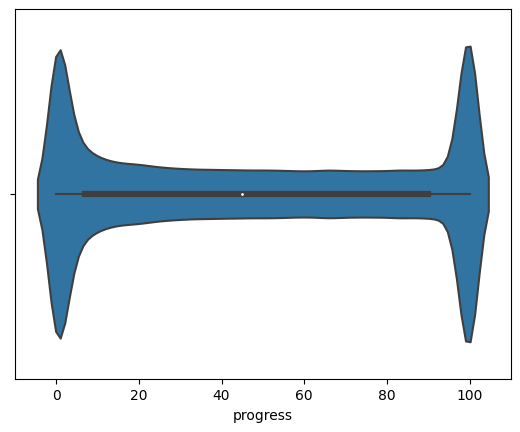

In [137]:
sns.violinplot(interactions.to_pandas(use_pyarrow_extension_array=True), x="progress")

In [138]:
minimum_interacted_items = 4

selected_user = interactions.lazy().groupby("user_id").agg(
    pl.count("item_id").alias("num_interacted_items")).filter(pl.col("num_interacted_items") >= minimum_interacted_items).collect().get_column("user_id").unique()

In [139]:
interactions = interactions.filter(pl.col("user_id").is_in(selected_user))

In [140]:
interval = timedelta(weeks=1)
start_date = interactions.get_column("start_date").max() - interval

cv = TimeRangeSplit(
    start_date=start_date, 
    interval=interval, 
    folds=5
)

In [141]:
train_index, test_index, fold_info = next(cv.split(interactions, datetime_column="start_date", fold_stats=True))

In [142]:
pl.from_dicts(fold_info)

Start date,End date,Train,New users,New users interactions,New items,New items interactions,Known interactions,Test
date,date,i64,i64,i64,i64,i64,i64,i64
2019-12-24,2019-12-31,1360648,0,0,0,0,0,12977


In [143]:
train_inter = interactions.join(train_index, on=["user_id", "item_id"], how="inner")

In [144]:
test_inter = interactions.join(test_index, on=["user_id", "item_id"], how="inner")

In [145]:
train_user_stat = compute_stat(train_inter)

In [146]:
train_pos_inter, train_neg_inter = get_pos_neg_samples(train_inter, train_user_stat)

In [147]:
assert train_pos_inter.get_column("user_id").n_unique() / train_inter.get_column("user_id").n_unique() == 1.0, "Not all users have pos samples"

In [148]:
train_neg_inter.get_column("user_id").n_unique() / train_inter.get_column("user_id").n_unique()

0.5705033411094856

In [149]:
users_without_neg_samples = train_pos_inter.join(train_neg_inter, on=["user_id"], how="anti").get_column("user_id").unique()

In [150]:
train_neg_inter.groupby("user_id").agg(pl.n_unique("item_id")).mean()

user_id,item_id
f64,f64
79697.17213,3.735151


In [151]:
simple_model = ImplicitRecommender(
    TFIDFRecommender(K=30),
)

In [152]:
simple_model.fit(train_inter, user_features=users, item_features=items)

/mnt/2TBHDD/users/kernela/conda-envs/education-recsys/lib/python3.10/site-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.008324384689331055 seconds
  warnings.warn(


In [153]:
predicted_recs = simple_model.recommend(train_inter.filter(pl.col("user_id").is_in(users_without_neg_samples)), num_recs_per_user=20)

In [154]:
del simple_model

In [155]:
train_neg_inter = train_neg_inter.select(pl.col("user_id", "item_id", "target")).vstack(
    predicted_recs.join(train_inter, on=["user_id", "item_id"], how="anti").select(pl.col("user_id", "item_id")).with_columns(pl.lit(0).alias("target"))
)

In [156]:
train_neg_inter.get_column("user_id").n_unique() / train_inter.get_column("user_id").n_unique()

1.0

In [157]:
train_neg_inter.groupby("user_id").agg(pl.n_unique("item_id")).mean()

user_id,item_id
f64,f64
79816.310869,10.720849


In [158]:
train_samples = train_pos_inter.select(pl.col("user_id", "item_id", "target")).vstack(train_neg_inter)

In [159]:
train_samples.head(n=3)

user_id,item_id,target
u32,u32,i32
126706,14433,1
127290,140952,1
46791,83486,1


In [160]:
user_features = users.with_columns(
    pl.col("sex").fill_null(-1),
    pl.col("age").cast(str).fill_null("unknown").cast(pl.Categorical)).select(pl.col("user_id", "age", "sex")).to_dummies(["age", "sex"])

In [161]:
user_features.head(n=3)

user_id,age_18_24,age_25_34,age_35_44,age_45_54,age_55_64,age_65_inf,age_unknown,sex_-1,sex_0,sex_1
u32,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8
1,0,0,0,1,0,0,0,1,0,0
2,1,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,1,0,0,1,0


In [162]:
model_path = hf_hub_download(repo_id="facebook/fasttext-ru-vectors", filename="model.bin")

In [163]:
model = fasttext.load_model(model_path)

In [164]:
fasttext.util.reduce_model(model, 100)

In [165]:
title_embeddings = []

In [166]:
for row in items.iter_rows(named=True):
    title_embeddings.append(model.get_sentence_vector(row["title"]).reshape(1, -1))

In [167]:
item_features = pl.DataFrame(np.concatenate(title_embeddings, axis=0)).hstack([items.get_column("item_id")])
del title_embeddings

In [168]:
dataset = TripletDataset(train_samples, user_features, item_features)

In [169]:
import torch
from torch.utils.data import DataLoader